In [1]:
import tushare as ts
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn import metrics,linear_model,svm,preprocessing,tree,ensemble,naive_bayes,neighbors
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import learning_curve,cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import ta
import random
import seaborn as sns

# Loading Data

In [2]:
CSI300 = ts.get_k_data('hs300',start='2005-04-08',end='2019-10-28')
CSI300 = CSI300.set_index('date')
CSI300 = CSI300.drop(columns=['code'])
features = CSI300

In [3]:
features.columns = ['Open','Adj Close','High','Low','Volume']
features

Open  Adj Close     High      Low      Volume
date                                                        
2005-04-08   984.66    1003.45  1003.70   979.53  14762500.0
2005-04-11  1003.88     995.42  1008.73   992.77  15936100.0
2005-04-12   993.71     978.70   993.71   978.20  10226200.0
2005-04-13   987.95    1000.90  1006.50   987.95  16071700.0
2005-04-14  1004.64     986.97  1006.42   985.58  12945700.0
...             ...        ...      ...      ...         ...
2019-10-22  3896.31    3895.88  3897.44  3870.55  68918566.0
2019-10-23  3892.68    3871.08  3901.42  3862.20  70198625.0
2019-10-24  3877.92    3870.67  3890.20  3852.58  71334575.0
2019-10-25  3871.77    3896.79  3899.72  3849.03  77453620.0
2019-10-28  3904.98    3926.58  3927.80  3897.82  97406020.0

[3539 rows x 5 columns]

# Feature Function

In [4]:
def ExpMovingAvg(data, window):
    weights = np.exp(np.linspace(-1.,0.,window))
    weights /= weights.sum()
    
    a = np.convolve(data,weights)[:len(data)]
    a[:window] = None
    return a

def EMA(window):
    weights = np.exp(np.linspace(-1.,0.,window))
    weights /= weights.sum()
    
    a = np.convolve(features['Adj Close'],weights)[:len(features['Adj Close'])]
    a[:window] = None
    features['EMA_'+str(window)] = a
    
def RSISMA(window):
    delta = features['Adj Close'].diff()
    
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = np.array(up.rolling(window=window).mean())
    roll_down = np.array(down.abs().rolling(window=window).mean())

    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    features['RSI_SMA'] = RSI
    
def RSIEMA(window):
    delta = features['Adj Close'].diff()
    
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = ExpMovingAvg(up,window)
    roll_down = ExpMovingAvg(down.abs(),window)

    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    features['RSI_EMA'] = RSI
    
def target(data):
    deltas = data.diff()
    target = [1 if delta >= 0 else 0 for delta in deltas]
    target[0] = 1
    return target

def MA(window):
    features['MA_'+str(window)] = features['Adj Close'].rolling(window=window).mean()
    
def MovingAvg(data, window):
    SMA = data.rolling(window=window).mean()
    return np.array(SMA)

def UB(window):
    UB = features['High']*(1 + 4 * (features['High']-features['Low']) / (features['High'] + features['Low']))
    MA = MovingAvg(UB,window)
    features['UB_'+str(window)] = MA
    
def DB(window):
    DB = features['Low']*(1 - 4 * (features['High']-features['Low']) / (features['High'] + features['Low']))
    MA = MovingAvg(DB,window)
    features['DB_'+str(window)] = MA
    
def PROC(window):
    features['PROC_'+str(window)] = (features['Adj Close'] - features['Adj Close'].shift(window))/features['Adj Close'].shift(window)
    
def MFI(window):
    features['MFI_'+str(window)] = ta.momentum.money_flow_index(features['High'], features['Low'], features['Close'], features['Volume'], n=window, fillna=False)
    
def STO_SIG(window):
    features['STO_SIG_'+str(window)] = ta.momentum.stoch_signal(features['High'], features['Low'], features['Adj Close'], n=14, d_n=window, fillna=False)
       
def UO(s,m,l,ws,wm,wl):
    features['UO_'+str(s)+'_'+str(m)+'_'+str(l)] = ta.momentum.uo(features['High'], features['Low'], features['Adj Close'], s=s, m=m, len=l, ws=ws, wm=wm, wl=wl, fillna=False)
    
def CMF(window):
    features['CMF_'+str(window)] = ta.volume.chaikin_money_flow(features['High'], features['Low'], features['Adj Close'], features['Volume'], n=window, fillna=False)
    
def EMV(window):
    features['EMV_'+str(window)] = ta.volume.ease_of_movement(features['High'], features['Low'], features['Adj Close'], features['Volume'], n=window, fillna=False)

def FI(window):
    features['FI_'+str(window)] = ta.volume.force_index(features['Adj Close'], features['Volume'], n=window, fillna=False)
    
def OBV():
    features['OBV'] = ta.volume.on_balance_volume(features['Adj Close'], features['Volume'], fillna=False)
    
def ATR(window):
    features['ATR_'+str(window)] = ta.volatility.average_true_range(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)
    
def BBHB(window):
    factor = input('# of factors to use for BBHB: ')
    factor = int(factor)
    features['BBHB_'+str(window)+'_'+str(factor)] = ta.volatility.bollinger_hband(features['Adj Close'], n=window, ndev=factor, fillna=False)

def BBLB(window):
    factor = input('# of factors to use for BBLB: ')
    factor = int(factor)
    features['BBLB_'+str(window)+'_'+str(factor)] = ta.volatility.bollinger_lband(features['Adj Close'], n=window, ndev=factor, fillna=False)
    
def BBHBI(window,factor):
    features['BBHBI_'+str(window)+'_'+str(factor)] = ta.volatility.bollinger_hband_indicator(features['Adj Close'], n=window, ndev=factor, fillna=False)

def BBMA(window):
    features['BBMA_'+str(window)] = ta.volatility.bollinger_mavg(features['Adj Close'], n=window, fillna=False)
    
def ROI(window):
    """return on investment"""
    features['ROI_'+str(window)] = (features['Adj Close'] - features['Adj Close'].shift(window))/features['Adj Close'].shift(window)
    
def DCHB(window):
    '''Donchian channel HighBand'''
    features['DCHB_'+str(window)] = ta.volatility.donchian_channel_hband(features['Adj Close'], n=window, fillna=False)
    
def DCLB(window):
    '''Donchian channel LowBand'''
    features['DCLB_'+str(window)] = ta.volatility.donchian_channel_lband(features['Adj Close'], n=window, fillna=False)

def KCC(window):
    features['KCC_'+str(window)] = ta.volatility.keltner_channel_central(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)
    
def KCHB(window):
    features['KCHB_'+str(window)] = ta.volatility.keltner_channel_hband(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)
    
def KCLB(window):
    features['KCLB_'+str(window)] = ta.volatility.keltner_channel_lband(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)
    
def ADXP(window):
    features['ADXP_'+str(window)] = ta.trend.adx_neg(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)

def AID(window):    
    features['AID_'+str(window)] = ta.trend.aroon_down(features['Adj Close'], n=window, fillna=False)
    
def AIU(window):    
    features['AIU_'+str(window)] = ta.trend.aroon_up(features['Adj Close'], n=window, fillna=False)
    
def CCI(window):
    features['CCI_'+str(window)] = ta.trend.cci(features['High'], features['Low'], features['Adj Close'], n=window, c=0.015, fillna=False)
    
def DPO(window):
    features['DPO_'+str(window)] = ta.trend.dpo(features['Adj Close'], n=window, fillna=False)
    
def ICH_A(window1,window2):
    features['ICH_A_'+str(window1)+'_'+str(window2)] = ta.trend.ichimoku_a(features['High'], features['Low'], n1=window1, n2=window2, visual=False, fillna=False)
    
def ICH_B(window1,window2):
    features['ICH_B_'+str(window1)+'_'+str(window2)] = ta.trend.ichimoku_b(features['High'], features['Low'], n2=window1, n3=window2, visual=False, fillna=False)

# Fixed Parameter Features

In [5]:
features['STO_OS'] = ta.momentum.stoch(features['High'], features['Low'], features['Adj Close'], n=14, fillna=False)
features['WillR'] = ta.momentum.wr(features['High'], features['Low'], features['Adj Close'], lbp=14, fillna=False)
features['MACD'] = ExpMovingAvg(features['Adj Close'],12) - ExpMovingAvg(features['Adj Close'],26)
features['SIG_LI'] = ExpMovingAvg(features['MACD'],9)
features['AO'] = ta.momentum.ao(features['High'], features['Low'], s=5, len=34, fillna=False)
features['VPT'] = ta.volume.volume_price_trend(features['Adj Close'], features['Volume'], fillna=False)
features['NVI'] = ta.volume.negative_volume_index(features['Adj Close'], features['Volume'], fillna=False)
features['ADI'] = ta.volume.acc_dist_index(features['High'], features['Low'], features['Adj Close'], features['Volume'], fillna=False)
features['KST'] = ta.trend.kst(features['Adj Close'], r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, fillna=False)

In [6]:
functions = [MA,STO_SIG,EMA,PROC,RSISMA,UB,DB,CMF,EMV,FI,BBHB,BBLB,BBMA,ROI,DCHB,DCLB,KCC,KCHB,KCLB,AID,AIU,CCI,DPO]

def Randomize_feature(number_of_features):
    for n in range(number_of_features):
        i = random.randint(0,len(functions)-1)
        window = random.randint(2,120) #number of periods(days)
        functions[i](window)

In [7]:
Randomize_feature(50)

# of factors to use for BBHB: 2
# of factors to use for BBLB: 2
# of factors to use for BBHB: 3
# of factors to use for BBLB: 4
# of factors to use for BBLB: 4


In [8]:
features['target'] = target(features['Adj Close'])
features = features.replace([np.inf, -np.inf], np.nan).dropna()

In [9]:
features

Open  Adj Close     High      Low      Volume     STO_OS  \
date                                                                      
2005-09-01   928.52     944.56   944.95   926.06  22306400.0  69.995940   
2005-09-02   945.98     947.87   947.92   941.31  18614400.0  76.715388   
2005-09-05   949.08     952.72   952.98   944.63  17843300.0  91.189050   
2005-09-06   953.41     936.61   956.30   934.97  21222300.0  56.736527   
2005-09-07   934.99     952.76   952.90   932.65  19608500.0  92.340978   
...             ...        ...      ...      ...         ...        ...   
2019-10-22  3896.31    3895.88  3897.44  3870.55  68918566.0  50.805639   
2019-10-23  3892.68    3871.08  3901.42  3862.20  70198625.0  36.930737   
2019-10-24  3877.92    3870.67  3890.20  3852.58  71334575.0  36.701354   
2019-10-25  3871.77    3896.79  3899.72  3849.03  77453620.0  51.314759   
2019-10-28  3904.98    3926.58  3927.80  3897.82  97406020.0  67.981426   

                WillR       MACD     SIG_LI         AO  ...  DCLB_52  \
date                                                    ...            
2005-09-01 -30.004060   7.668312  31.063558  17.490706  ...   824.10   
2005-09-02 -23.284612   2.653025  26.601839  17.968176  ...   824.10   
2005-09-05  -8.810950   1.885862  22.133393  20.162441  ...   824.10   
2005-09-06 -43.263473   0.666491  17.675660  22.831206  ...   824.10   
2005-09-07  -7.659022  -0.597854  13.316846  24.387735  ...   824.10   
...               ...        ...        ...        ...  ...      ...   
2019-10-22 -49.194361 -27.857698 -22.771573  12.252853  ...  3621.43   
2019-10-23 -63.069263 -13.916835 -26.660815  -1.911118  ...  3621.43   
2019-10-24 -63.298646  -3.107088 -28.764873 -14.955824  ...  3621.43   
2019-10-25 -48.685241   6.538724 -28.482125 -22.703294  ...  3621.43   
2019-10-28 -32.018574  15.933270 -25.110416 -16.719588  ...  3633.53   

            STO_SIG_75         FI_13         FI_99      BBMA_53    BBLB_59_4  \
date                                                                           
2005-09-01   51.470334 -1.864346e+07 -4.442603e+08   893.827170   745.483525   
2005-09-02   52.242203 -1.474519e+07 -1.273532e+08   894.802642   743.662309   
2005-09-05   53.438233  1.048205e+06 -1.978923e+08   895.785094   741.853148   
2005-09-06   54.003862 -1.694900e+08 -3.311321e+08   896.597170   742.269878   
2005-09-07   55.037670 -7.828842e+07 -2.279344e+08   897.624717   741.009883   
...                ...           ...           ...          ...          ...   
2019-10-22   55.012218 -1.849103e+09 -1.032452e+10  3832.574906  3460.355250   
2019-10-23   54.194391 -7.013208e+07 -9.481252e+09  3833.850566  3460.813647   
2019-10-24   53.565130  3.033391e+08 -4.553034e+09  3836.175660  3460.775179   
2019-10-25   53.220423  4.703737e+07 -4.281197e+09  3840.347358  3460.243034   
2019-10-28   53.009678  1.796103e+09  2.428856e+09  3845.823774  3458.623688   

               AID_33   PROC_71   PROC_47  target  
date                                               
2005-09-01   3.030303  0.087639  0.045191       1  
2005-09-02   3.030303  0.105607  0.054478       1  
2005-09-05   3.030303  0.121494  0.084250       1  
2005-09-06   6.060606  0.094669  0.089728       0  
2005-09-07   3.030303  0.113102  0.113128       1  
...               ...       ...       ...     ...  
2019-10-22   3.030303  0.000688  0.061753       1  
2019-10-23   3.030303  0.017958  0.065377       0  
2019-10-24  60.606061  0.020442  0.046382       0  
2019-10-25  57.575758  0.029062  0.063027       1  
2019-10-28  54.545455  0.037345  0.066310       1  

[3438 rows x 65 columns]

# Data Processing

In [10]:
#Standardized Dataset
features_target = features.loc[:,'STO_OS':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Adj Close']

# Feature Importance 

In [11]:
##Feature Importance
model = ensemble.ExtraTreesClassifier(n_estimators=100)
model.fit(X,Y['target'])
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
#plt.figure(figsize=(20,20))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#feat_importances.nsmallest(len(X.columns)).plot(kind='barh')
#plt.show()
feat_importances = feat_importances.sort_values(ascending=False).iloc[:30]
df1 = feat_importances
df1

STO_OS        0.098491
WillR         0.095438
AID_11        0.068579
ADI           0.049039
VPT           0.040674
AID_33        0.027236
AID_35        0.023741
AIU_75        0.020249
AIU_108       0.019983
RSI_SMA       0.019806
FI_13         0.018089
DPO_24        0.017835
STO_SIG_16    0.017426
FI_91         0.016167
AO            0.016016
CMF_105       0.015998
CMF_62        0.015919
AID_99        0.015286
FI_99         0.015154
DPO_92        0.014912
DPO_84        0.014897
PROC_47       0.014666
ROI_75        0.014203
MACD          0.014106
PROC_71       0.013928
PROC_82       0.013927
SIG_LI        0.013089
KST           0.012033
STO_SIG_98    0.011828
STO_SIG_75    0.011558
dtype: float64

In [12]:
def modelfit(alg, X, Y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X, Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X, Y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(Y.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(Y, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(10,10))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

# XGB_PCA Model

In [13]:
#PCA Analysis
#We keep 25 components to make sure the sum of explained variation of the principal components is close to 98%
#To improve accuracy and efficiency
pca = PCA(n_components=25)
X = pd.DataFrame(pca.fit_transform(X),index=X.index)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum of Explained variation of principal component: {}'.format(sum(pca.explained_variance_ratio_)))

#Data Set Preparation 
X_test = X.iloc[int(len(X.index)*0.6):]
X_train = X.iloc[:int(len(X.index)*0.6)]
y_test = Y.iloc[int(len(Y.index)*0.6):]
Y_train = Y.iloc[:int(len(Y.index)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

Explained variation per principal component: [4.20148391e-01 2.77856007e-01 9.36190467e-02 5.70241090e-02
 3.28564536e-02 2.05401649e-02 1.75048143e-02 1.54917296e-02
 1.44923580e-02 9.84764956e-03 7.84373702e-03 6.88585419e-03
 5.61548657e-03 2.90207877e-03 2.55914110e-03 2.41263126e-03
 1.98115139e-03 1.61210759e-03 1.46112856e-03 1.27173365e-03
 1.02086174e-03 8.74297597e-04 7.48541348e-04 4.93253690e-04
 3.98976696e-04]
Sum of Explained variation of principal component: 0.9974617046119721


In [14]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

(1443, 25) (1443, 2)
(619, 25) (619, 2)
(1376, 25) (1376, 2)



Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.7513934 | Std - 0.02201651 | Min - 0.7242626 | Max - 0.7890443


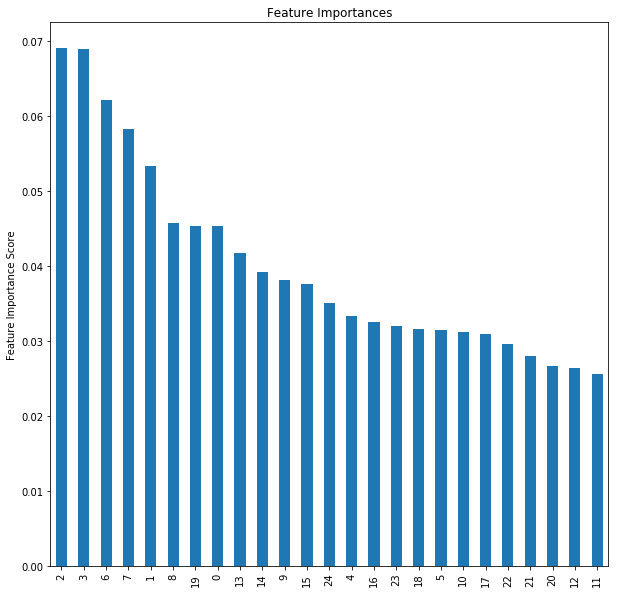

In [15]:
#XGBoost Hyperparameters tuning 
#creating a baseline model without tuning (assuming initial values)
XGB0 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB0, X_train, y_train['target'])

In [16]:
#XGBoost: learning_rate, n_estimators
param_test1 = {
    'learning_rate':[0.0001,0.001,0.005,0.01,0.05,0.1],
    'n_estimators':[100,200,300,400,500,800,1000]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train, y_train['target'])
print('1:',gsearch1.best_params_, gsearch1.best_score_)

#XGBoost: max_depth, min_child_weight
param_test2 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train, y_train['target'])
print('2:',gsearch2.best_params_, gsearch2.best_score_)

#XGBoost: gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train, y_train['target'])
print('3:',gsearch3.best_params_, gsearch3.best_score_)

#XGBoost: subsample, colsample_bytree
param_test4 = {
 'subsample':[i/100.0 for i in range(60,100,5)],
 'colsample_bytree':[i/100.0 for i in range(60,100,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train, y_train['target'])
print('4:',gsearch4.best_params_, gsearch4.best_score_)

#XGBoost: reg_alpha
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], colsample_bytree=gsearch4.best_params_['colsample_bytree'],
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train, y_train['target'])
print('5:',gsearch5.best_params_, gsearch5.best_score_)

1: {'learning_rate': 0.01, 'n_estimators': 300} 0.7703455900824322
2: {'max_depth': 5, 'min_child_weight': 5} 0.7738742982164034
3: {'gamma': 0.1} 0.7747954530849268
4: {'colsample_bytree': 0.85, 'subsample': 0.65} 0.7781388932704723
5: {'reg_alpha': 1e-05} 0.7781388932704723



Model Report
Accuracy : 0.8441
AUC Score (Train): 0.941368
CV Score : Mean - 0.7781389 | Std - 0.02304234 | Min - 0.7423848 | Max - 0.8113345


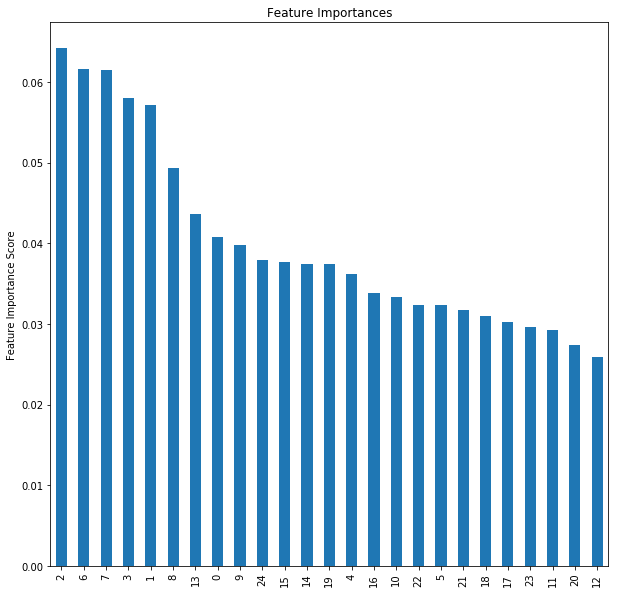

In [17]:
XGB_PCA = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], 
                     max_depth=gsearch2.best_params_['max_depth'],min_child_weight=gsearch2.best_params_['min_child_weight'], 
                     gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], 
                     colsample_bytree=gsearch4.best_params_['colsample_bytree'], reg_alpha=gsearch5.best_params_['reg_alpha'],objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(XGB_PCA, X_train, y_train['target'])

In [18]:
#Default XGBoost
x_prediction = X_val
model = XGBClassifier()        
print("# Training 'Default XGBoost'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#Initial XGB0
x_prediction = X_val
model = XGB0        
print("# Training 'XGB0'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#XBG_PCA
x_prediction = X_val
model = XGB_PCA   
print("# Training 'XGB_PCA'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))

# Training 'Default XGBoost'
# Predicting...
- probabilities: [0.2158699  0.5457651  0.5221609  0.5604579  0.18533829]
- accuracy:  0.715670436187399
- validation logloss: 0.552203672479158


# Training 'XGB0'
# Predicting...
- probabilities: [0.02718144 0.41257587 0.8958041  0.7174161  0.02284196]
- accuracy:  0.6946688206785138
- validation logloss: 0.9274277548639961


# Training 'XGB_PCA'
# Predicting...
- probabilities: [0.3069111  0.57146966 0.54412603 0.5213718  0.26649913]
- accuracy:  0.7205169628432956
- validation logloss: 0.5651636948517144


Since the overall performance of Default XGB is better than both inital XGB0 and XGB_PCA, we pick Default as our prediction model

In [23]:
#XGB_PCA test_data prediction
model = XGB_PCA
model.fit(X_train, y_train['target'])
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'PCA prediction': results},index=X_test.index)
Close = pd.DataFrame(data={'PCA Close': y_test['Close']})
prob = prob.join(Close)

In [24]:
prob

PCA prediction  PCA Close
date                                 
2014-03-06               0    2173.63
2014-03-07               0    2168.36
2014-03-10               0    2097.79
2014-03-11               0    2108.66
2014-03-12               0    2114.13
...                    ...        ...
2019-10-22               0    3895.88
2019-10-23               0    3871.08
2019-10-24               0    3870.67
2019-10-25               1    3896.79
2019-10-28               1    3926.58

[1376 rows x 2 columns]

In [25]:
# PCA Performance

In [26]:
#assuming zero risk free rate
#sharpe ratio 
#max drawdown
#absolute return
performance_df = pd.DataFrame(index=['Sharpe_Ratio (per transaction)','Sharpe_Ratio (Annualized)','Max_Drawdown','Absolute_return'])
def performance(prediction, close):
    Investment=[]
    Capital=[]
    Prices=[]
    for i in range(len(prediction)):
        if prediction.iloc[i]==1:
            Prices.append(close.iloc[i])
        if i==0 and prediction.iloc[i]==1:
            Capital.append(close.iloc[i])
        if i>0 and prediction.iloc[i-1]==0 and prediction.iloc[i]==1:
            Capital.append(close.iloc[i])
        if i>0 and prediction.iloc[i-1]==1 and prediction.iloc[i]==0:
            Investment.append(close.iloc[i])
            Prices.append(close.iloc[i])
        if i==len(prediction)-1 and prediction.iloc[i]==1:
            Investment.append(close.iloc[i])
    absolute_return=np.log(np.sum(Investment)/np.sum(Capital))
    returns = pd.DataFrame(np.log(np.array(Investment)/np.array(Capital))).replace([np.inf, -np.inf], np.nan).dropna()
    avg_return = float(np.mean(returns))
    std = float(np.std(returns))
    SR = avg_return/std
    SR_ann = SR*(len(Investment)**0.5)/(len(Prices)**0.5)*(252**0.5)
    max_drawdown = (min(Prices)-max(Prices))/max(Prices)
    return SR, SR_ann, max_drawdown, absolute_return
results = performance(prob['PCA prediction'],prob['PCA Close'])
performance_df['XGB_PCA'] = results
performance_df

XGB_PCA
Sharpe_Ratio (per transaction)  0.021304
Sharpe_Ratio (Annualized)       0.145898
Max_Drawdown                   -0.604924
Absolute_return                 0.000469

# Benchmark learning (all features included)

In [32]:
features_target = features.loc[:,'STO_OS':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Adj Close']

In [33]:
#Data Set Preparation 
X_test = X.iloc[int(len(X.index)*0.6):]
X_train = X.iloc[:int(len(X.index)*0.6)]
y_test = Y.iloc[int(len(Y.index)*0.6):]
Y_train = Y.iloc[:int(len(Y.index)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

In [34]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

(1443, 59) (1443, 2)
(619, 59) (619, 2)
(1376, 59) (1376, 2)



Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.895956 | Std - 0.008869618 | Min - 0.881338 | Max - 0.9051573


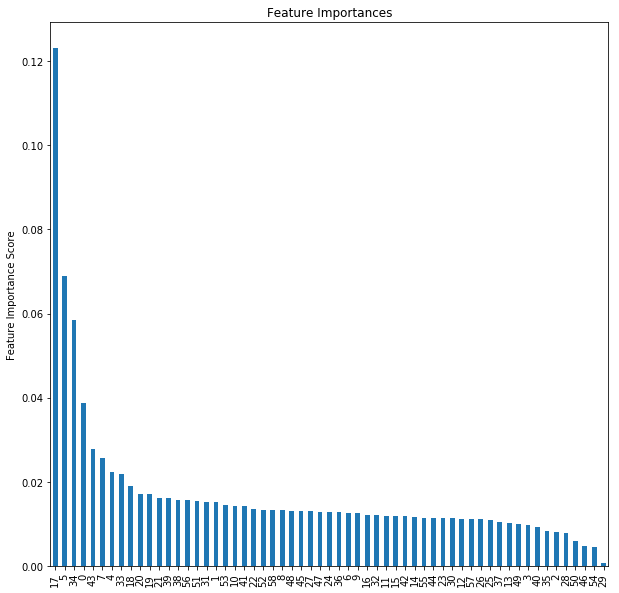

In [35]:
#XGBoost Hyperparameters tuning 
#creating a baseline model without tuning (assuming initial values)
XGB0 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB0, X_train, y_train['target'])

In [37]:
#XGBoost: learning_rate, n_estimators
param_test1 = {
    'learning_rate':[0.0001,0.001,0.005,0.01,0.05,0.1],
    'n_estimators':[100,200,300,400,500,800,1000]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train, y_train['target'])
print('1:',gsearch1.best_params_, gsearch1.best_score_)

#XGBoost: max_depth, min_child_weight
param_test2 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train, y_train['target'])
print('2:',gsearch2.best_params_, gsearch2.best_score_)

#XGBoost: gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train, y_train['target'])
print('3:',gsearch3.best_params_, gsearch3.best_score_)

#XGBoost: subsample, colsample_bytree
param_test4 = {
 'subsample':[i/100.0 for i in range(60,100,5)],
 'colsample_bytree':[i/100.0 for i in range(60,100,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train, y_train['target'])
print('4:',gsearch4.best_params_, gsearch4.best_score_)

#XGBoost: reg_alpha
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], colsample_bytree=gsearch4.best_params_['colsample_bytree'],
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train, y_train['target'])
print('5:',gsearch5.best_params_, gsearch5.best_score_)

1: {'learning_rate': 0.005, 'n_estimators': 800} 0.9302227012753329
2: {'max_depth': 3, 'min_child_weight': 2} 0.9309333940912887
3: {'gamma': 0.2} 0.9309915230967862
4: {'colsample_bytree': 0.65, 'subsample': 0.95} 0.9324809693230746
5: {'reg_alpha': 1e-05} 0.9324809693230746



Model Report
Accuracy : 0.8524
AUC Score (Train): 0.950160
CV Score : Mean - 0.932481 | Std - 0.007597847 | Min - 0.9242424 | Max - 0.9466937


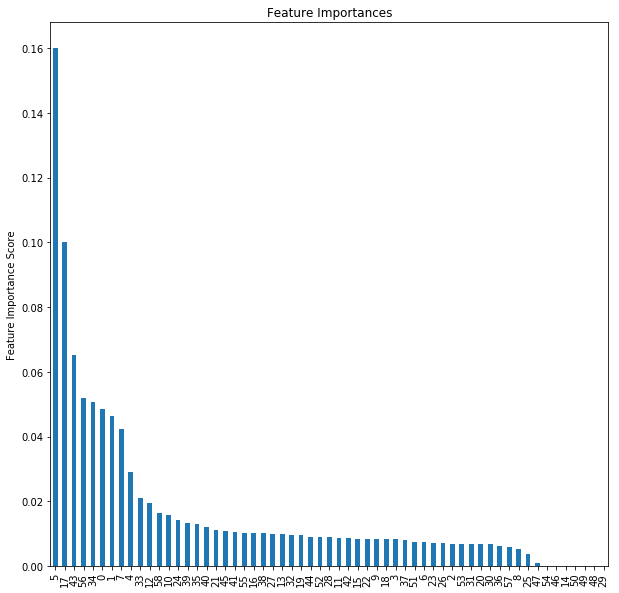

In [38]:
XGB_Bench = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], 
                     max_depth=gsearch2.best_params_['max_depth'],min_child_weight=gsearch2.best_params_['min_child_weight'], 
                     gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], 
                     colsample_bytree=gsearch4.best_params_['colsample_bytree'], reg_alpha=gsearch5.best_params_['reg_alpha'],objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(XGB_Bench, X_train, y_train['target'])

In [39]:
#Default XGBoost
x_prediction = X_val
model = XGBClassifier()        
print("# Training 'Default XGBoost'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#Initial XGB0
x_prediction = X_val
model = XGB0        
print("# Training 'XGB0'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#XBG_Bench
x_prediction = X_val
model = XGB_Bench  
print("# Training 'XGB_Bench'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))

# Training 'Default XGBoost'
# Predicting...
- probabilities: [0.00610512 0.26760313 0.88203305 0.496023   0.14363451]
- accuracy:  0.8610662358642972
- validation logloss: 0.28656054499765227


# Training 'XGB0'
# Predicting...
- probabilities: [3.4002744e-04 3.2774046e-02 9.5022905e-01 2.7735761e-01 1.1911637e-03]
- accuracy:  0.8109854604200323
- validation logloss: 0.48310680385392923


# Training 'XGB_Bench'
# Predicting...
- probabilities: [0.01849428 0.31418338 0.82130486 0.41978142 0.2380467 ]
- accuracy:  0.8529886914378029
- validation logloss: 0.31733155812953806


 We will pick Default XGB as our prediction model, since it performs with better accuracy and lower validation logloss.

In [46]:
#Default XGBoost
model = XGBClassifier() 
model.fit(X_train, y_train['target'])
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'Bench prediction': results},index=X_test.index)
Close = pd.DataFrame(data={'Bench Close': y_test['Close']})
prob = prob.join(Close)
prob

Bench prediction  Bench Close
date                                     
2014-03-06                 0      2173.63
2014-03-07                 1      2168.36
2014-03-10                 0      2097.79
2014-03-11                 1      2108.66
2014-03-12                 0      2114.13
...                      ...          ...
2019-10-22                 1      3895.88
2019-10-23                 0      3871.08
2019-10-24                 0      3870.67
2019-10-25                 1      3896.79
2019-10-28                 1      3926.58

[1376 rows x 2 columns]

In [47]:
#Benchmark Performance

In [48]:
#assuming zero risk free rate
#sharpe ratio 
#max drawdown
#absolute return
results = performance(prob['Bench prediction'],prob['Bench Close'])
performance_df['XGB_Bench'] = results
performance_df

XGB_PCA  XGB_Bench
Sharpe_Ratio (per transaction)  0.021304   0.019257
Sharpe_Ratio (Annualized)       0.145898   0.160038
Max_Drawdown                   -0.604924  -0.608164
Absolute_return                 0.000469   0.000475

# PCA_DWT

In [49]:
features_target = features.loc[:,'STO_OS':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Adj Close']

In [50]:
#We keep 25 components to make sure the sum of explained variation of the principal components is close to 98%
#To improve accuracy and efficiency
pca = PCA(n_components=25)
X = pd.DataFrame(pca.fit_transform(X),index=X.index)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum of Explained variation of principal component: {}'.format(sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [4.20148391e-01 2.77856007e-01 9.36190467e-02 5.70241090e-02
 3.28564536e-02 2.05401649e-02 1.75048143e-02 1.54917296e-02
 1.44923580e-02 9.84764956e-03 7.84373702e-03 6.88585419e-03
 5.61548657e-03 2.90207877e-03 2.55914110e-03 2.41263126e-03
 1.98115139e-03 1.61210759e-03 1.46112856e-03 1.27173365e-03
 1.02086174e-03 8.74297598e-04 7.48541401e-04 4.93253893e-04
 3.98988402e-04]
Sum of Explained variation of principal component: 0.9974617165756076


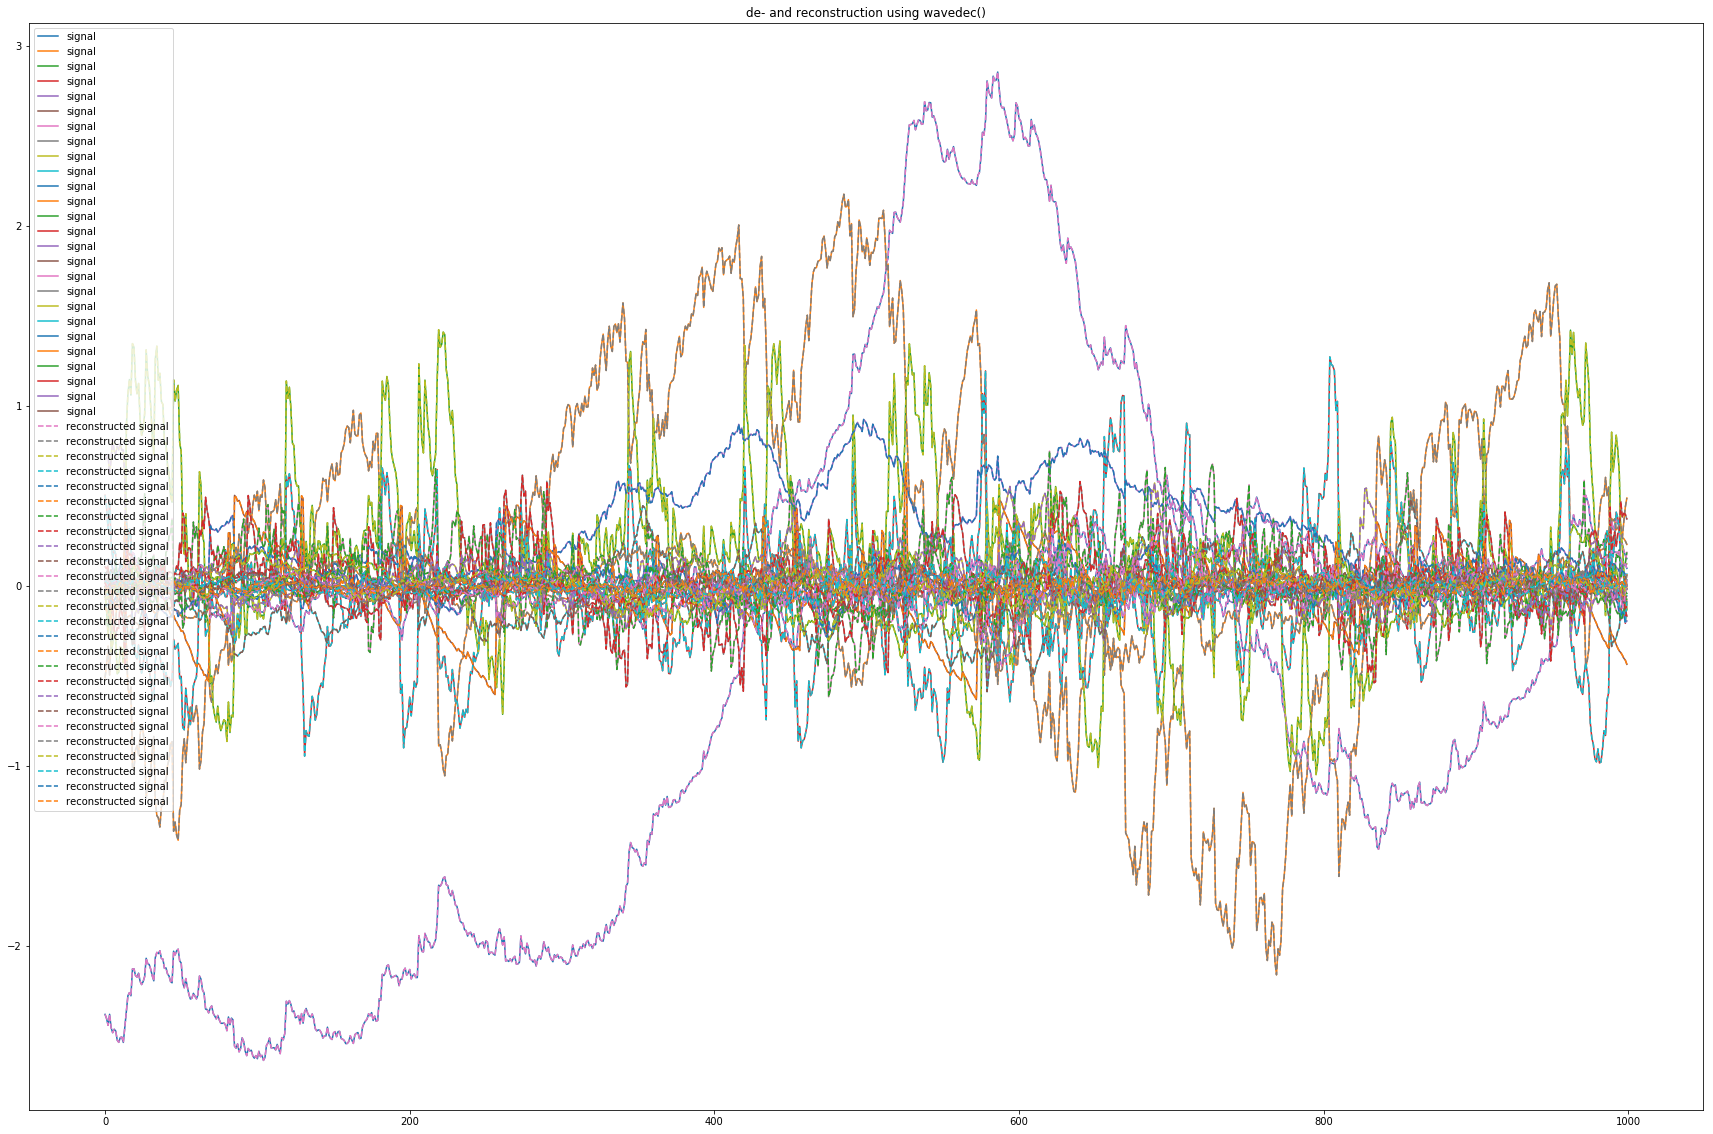

In [51]:
import pywt
coeffs = pywt.wavedec(X, 'db2', level=3)
X = pywt.waverec(coeffs, 'db2')
 
fig, ax = plt.subplots(figsize=(30,20))
ax.plot(X[:1000], label='signal')
ax.plot(X[:1000], label='reconstructed signal', linestyle='--')
ax.legend(loc='upper left')
ax.set_title('de- and reconstruction using wavedec()')
plt.show()

In [52]:
#Data Set Preparation 
X_test = X[int(len(X)*0.6):]
X_train = X[:int(len(X)*0.6)]
y_test = Y[int(len(Y)*0.6):]
Y_train = Y[:int(len(Y)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

In [53]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

(1443, 26) (1443, 2)
(619, 26) (619, 2)
(1376, 26) (1376, 2)



Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.7501618 | Std - 0.01667915 | Min - 0.7236842 | Max - 0.772873


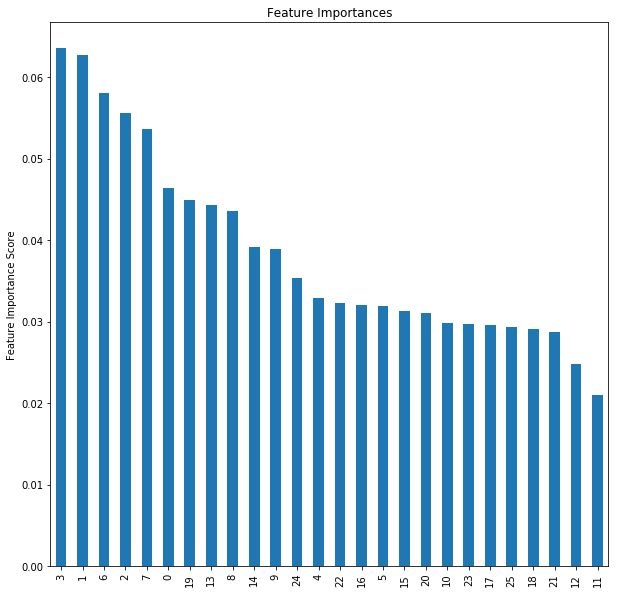

In [54]:
#XGBoost Hyperparameters tuning 
#creating a baseline model without tuning (assuming initial values)
XGB0 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB0, X_train, y_train['target'])

In [55]:
#XGBoost: learning_rate, n_estimators
param_test1 = {
    'learning_rate':[0.0001,0.001,0.005,0.01,0.05,0.1],
    'n_estimators':[100,200,300,400,500,800,1000]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train, y_train['target'])
print('1:',gsearch1.best_params_, gsearch1.best_score_)

#XGBoost: max_depth, min_child_weight
param_test2 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train, y_train['target'])
print('2:',gsearch2.best_params_, gsearch2.best_score_)

#XGBoost: gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train, y_train['target'])
print('3:',gsearch3.best_params_, gsearch3.best_score_)

#XGBoost: subsample, colsample_bytree
param_test4 = {
 'subsample':[i/100.0 for i in range(60,100,5)],
 'colsample_bytree':[i/100.0 for i in range(60,100,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train, y_train['target'])
print('4:',gsearch4.best_params_, gsearch4.best_score_)

#XGBoost: reg_alpha
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], colsample_bytree=gsearch4.best_params_['colsample_bytree'],
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train, y_train['target'])
print('5:',gsearch5.best_params_, gsearch5.best_score_)

1: {'learning_rate': 0.01, 'n_estimators': 300} 0.7699828680091837
2: {'max_depth': 4, 'min_child_weight': 5} 0.7726090430037799
3: {'gamma': 0.8} 0.7730805013699751
4: {'colsample_bytree': 0.6, 'subsample': 0.9} 0.7765279311331943
5: {'reg_alpha': 1e-05} 0.7765279311331943



Model Report
Accuracy : 0.8281
AUC Score (Train): 0.918653
CV Score : Mean - 0.7765279 | Std - 0.02419629 | Min - 0.7439271 | Max - 0.8136169


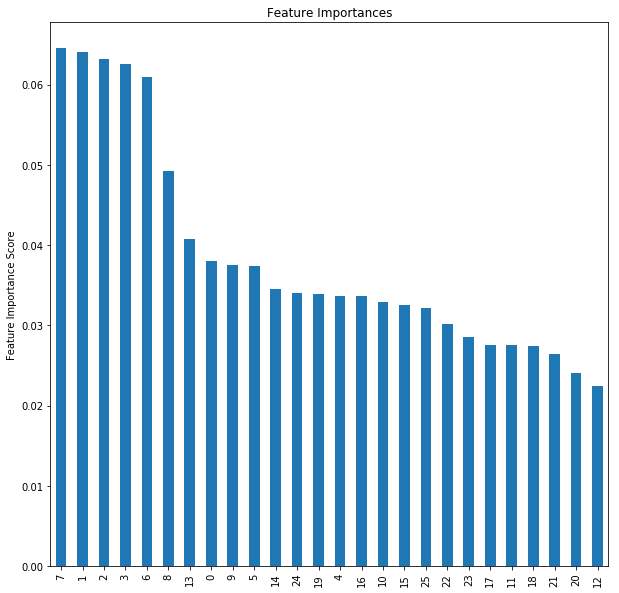

In [56]:
XGB_PCA_DWT = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], 
                     max_depth=gsearch2.best_params_['max_depth'],min_child_weight=gsearch2.best_params_['min_child_weight'], 
                     gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], 
                     colsample_bytree=gsearch4.best_params_['colsample_bytree'], reg_alpha=gsearch5.best_params_['reg_alpha'],objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(XGB_PCA_DWT, X_train, y_train['target'])

In [57]:
#Default XGBoost
x_prediction = X_val
model = XGBClassifier()        
print("# Training 'Default XGBoost'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#Initial XGB0
x_prediction = X_val
model = XGB0        
print("# Training 'XGB0'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#XBG_PCA_DWT
x_prediction = X_val
model = XGB_PCA_DWT  
print("# Training 'XGB_PCA_DWT'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))

# Training 'Default XGBoost'
# Predicting...
- probabilities: [0.27678856 0.5373838  0.5061927  0.54131585 0.15981843]
- accuracy:  0.7140549273021002
- validation logloss: 0.5477862104544828


# Training 'XGB0'
# Predicting...
- probabilities: [0.04561216 0.3411563  0.8994645  0.7461103  0.04488765]
- accuracy:  0.6930533117932148
- validation logloss: 0.9107375137967274


# Training 'XGB_PCA_DWT'
# Predicting...
- probabilities: [0.35306522 0.5422916  0.4989496  0.5267744  0.31988573]
- accuracy:  0.7172859450726979
- validation logloss: 0.5738995090632524


In [60]:
#Default
model = XGB_PCA_DWT
model.fit(X_train, y_train['target'])
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'XGB_PCA_DWT prediction': results},index=y_test.index)
Close = pd.DataFrame(data={'XGB_PCA_DWT Close': y_test['Close']})
prob = prob.join(Close)
prob

XGB_PCA_DWT prediction  XGB_PCA_DWT Close
date                                                 
2014-03-06                       0            2173.63
2014-03-07                       0            2168.36
2014-03-10                       0            2097.79
2014-03-11                       0            2108.66
2014-03-12                       0            2114.13
...                            ...                ...
2019-10-22                       0            3895.88
2019-10-23                       0            3871.08
2019-10-24                       0            3870.67
2019-10-25                       1            3896.79
2019-10-28                       1            3926.58

[1376 rows x 2 columns]

In [61]:
results = performance(prob['XGB_PCA_DWT prediction'],prob['XGB_PCA_DWT Close'])
performance_df['XGB_PCA_DWT'] = results
performance_df

XGB_PCA  XGB_Bench  XGB_PCA_DWT
Sharpe_Ratio (per transaction)  0.021304   0.019257     0.020494
Sharpe_Ratio (Annualized)       0.145898   0.160038     0.136233
Max_Drawdown                   -0.604924  -0.608164    -0.604924
Absolute_return                 0.000469   0.000475     0.000502

# SGD

In [62]:
features_target = features.loc[:,'STO_OS':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Adj Close']

In [63]:
#Data Set Preparation 
X_test = X[int(len(X)*0.6):]
X_train = X[:int(len(X)*0.6)]
y_test = Y[int(len(Y)*0.6):]
Y_train = Y[:int(len(Y)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)

(1443, 59) (1443, 2)
(619, 59) (619, 2)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    5.0s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    5.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    5.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.1s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.7s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.8s finished


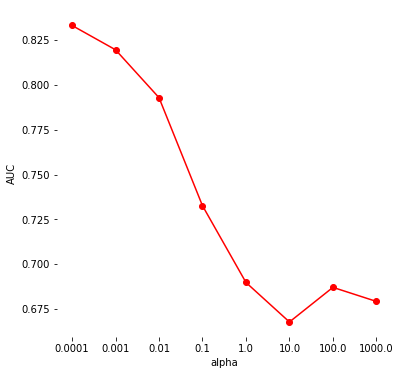

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 0.8329966117389566


In [64]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf

grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'n_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

In [65]:
#Best SGD
x_prediction = X_val
model = bestModel
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'SGD prediction': results},index=y_test.index)
Close = pd.DataFrame(data={'SGD Close': y_test['Close']})
prob = prob.join(Close)
prob

# Training...
# Predicting...
- probabilities: [0.16146116 0.4324744  0.59575649 0.36668797 0.15368351]
- accuracy:  0.7447495961227787
- validation logloss: 0.5077086245556957




SGD prediction  SGD Close
date                                 
2014-03-06               0    2173.63
2014-03-07               0    2168.36
2014-03-10               0    2097.79
2014-03-11               0    2108.66
2014-03-12               0    2114.13
...                    ...        ...
2019-10-22               1    3895.88
2019-10-23               0    3871.08
2019-10-24               0    3870.67
2019-10-25               1    3896.79
2019-10-28               1    3926.58

[1376 rows x 2 columns]

In [66]:
results = performance(prob['SGD prediction'],prob['SGD Close'])
performance_df['SGD'] = results
performance_df

XGB_PCA  XGB_Bench  XGB_PCA_DWT       SGD
Sharpe_Ratio (per transaction)  0.021304   0.019257     0.020494 -0.016513
Sharpe_Ratio (Annualized)       0.145898   0.160038     0.136233 -0.125855
Max_Drawdown                   -0.604924  -0.608164    -0.604924 -0.601986
Absolute_return                 0.000469   0.000475     0.000502 -0.000557